(c) 2020, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# import simulated data
data_simulated = pd.read_csv('./ECG_data/SimulatedECG.txt', sep=" ", header=1)
data_simulated.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

In [3]:
# import measured data
data_measured = pd.read_csv('./ECG_data/MeasuredECG.txt', sep=" ", header=1)
data_measured.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

<IPython.core.display.Javascript object>


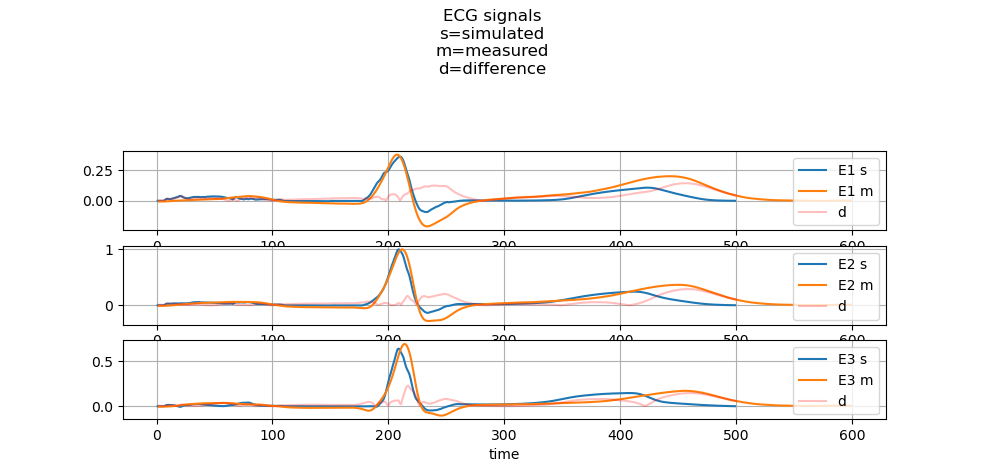

In [4]:
%matplotlib notebook
#fig = plt.figure(figsize=(8.5, 10.5))
fig = plt.figure()
fig.suptitle('ECG signals\ns=simulated\nm=measured\nd=difference')

header = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']
#l = len(header)
l = 4
for i in range(l):
    if header[i] == 'time': continue

    fig.add_subplot(l, 1, i + 1)
    plt.plot(data_simulated['time'], data_simulated[header[i]], label=header[i] + ' s')
    plt.plot(data_measured['time'], data_measured[header[i]], label=header[i] + ' m')
    plt.plot(data_measured['time'], abs(data_simulated[header[i]] - data_measured[header[i]]), c='r', alpha=.25, label='d')
    plt.grid()
    plt.legend(loc='upper right')

plt.xlabel('time')
plt.show()

# Crosscorrelation analysis
Using the 2x9 (9 simulated, 9 measures) ECG time series as $x(t)$ or $y(t)$. The formula for the crosscorrelation reads:

$$
K(\tau) = \int_{-\infty}^{\infty} x(t)y(t+\tau) dt
$$

The ECG time series are present as discrete signals $x_i, y_i$, so that the above formula can be written as, and normalized by the effective value:

$$
K(\tau) = \frac{\sum_{i=1}^N x_i\cdot y_{i + \tau}}{\sqrt{\sum_{i=1}^N (x_i)^2 \cdot \sum_{i=1}^N (y_{i+\tau})^2}}
$$

Please note that all signals are calculated from measurements $LA, LL, RA, V1 ... V6$ in the following manner:

$$
E1 = LA - RA
\\
E2 = LL - RA
\\
E3 = LL -LA
\\
W1 = V1 - norm
\\
W2 = V2 - norm
\\
W3 = V3 - norm
\\
W4 = V4 - norm
\\
W5 = V5 - norm
\\
W6 = V6 - norm
$$

where $norm = \frac{LA + RA + LL}{3}$. The electrode positions are displayed in the following figure: 

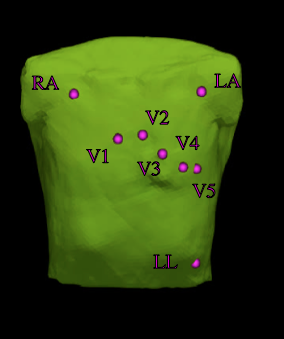

Trivially we expect a strong correlation between the channels.

Starting by implementing the crosscorrelation function:

In [83]:
def discrete_cross_correlation_normalized(x, y, tau_min, tau_max):
    r = []
    for tau in range(tau_min, tau_max):
        eff = np.sqrt(np.sum(x ** 2) * np.sum(np.roll(y, tau) ** 2))
        numerator = np.sum(x * np.roll(y, tau))

        r.append(numerator / eff)
        
    return r

For an example this function is applied to simulated channels $E1$ and $E2$:

In [77]:
o = discrete_cross_correlation_normalized(data_simulated['E1'], data_simulated['E2'], \
                                          0, len(data_simulated['E1']))

<IPython.core.display.Javascript object>


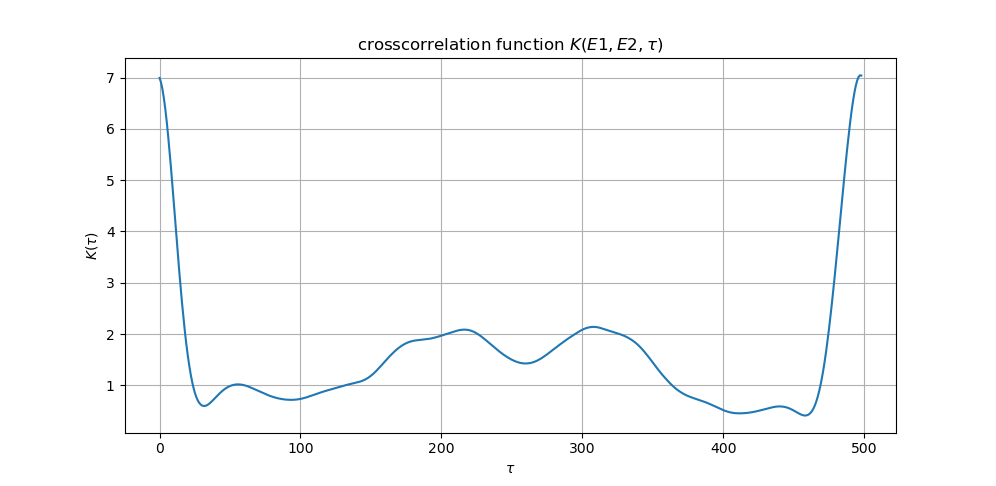

In [78]:
%matplotlib notebook
plt.plot(o)
plt.grid()
plt.xlabel('$\\tau$')
plt.ylabel('$K(\\tau)$')
plt.title('crosscorrelation function $K(E1, E2, \\tau)$')
plt.show()

Note that these signals are quite simmilar, as well as all other series in the dataset, so that there is practically no remarkable correlation with varied $\tau$. Also the used dataset only provides one period of the signal, which further reduces the crosscorrelation.

Using the mean of the crosscorrelation, drawing a crosscorrelation matrix for all nine channels:

In [90]:
header = ['E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

r = []
tau = []
for el in header:
    r_ = []
    tau_ = []
    for sel in header:
        tmp = discrete_cross_correlation_normalized(data_simulated[el], data_simulated[sel], \
                                                    0, len(data_simulated[el]))
        # since we are interested in the most extreme value of the crosscorrelation
        extreme = np.max(tmp) if np.abs(np.max(tmp)) > np.abs(np.min(tmp)) else np.min(tmp)

        # the value of tau, where the extreme correlation is
        tau__ = np.where(tmp == extreme)[0]
        
        tau_.append(tau__[0])       
        r_.append(extreme)
    tau.append(tau_)
    r.append(r_)

<IPython.core.display.Javascript object>


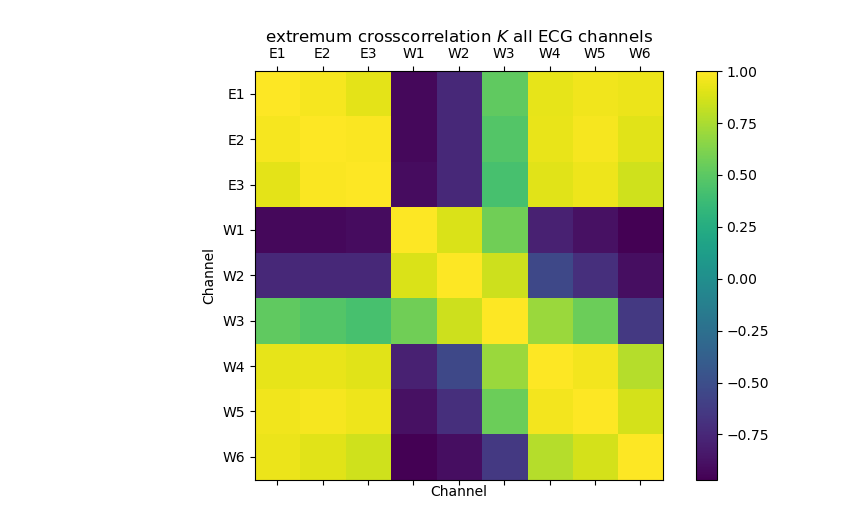

In [85]:
%matplotlib notebook
plt.matshow(r)
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.colorbar()
plt.title('extremum crosscorrelation $K$ all ECG channels')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6'])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6'])
plt.show()

From the diagram above, one can conclude that most of the signals are mostly in phase with each other, and no remarkable crossorrelation can be identified. Except for channels $W1...W3$ which are out of phase with channels $E1...E3$ and $W4...W6$.

<IPython.core.display.Javascript object>


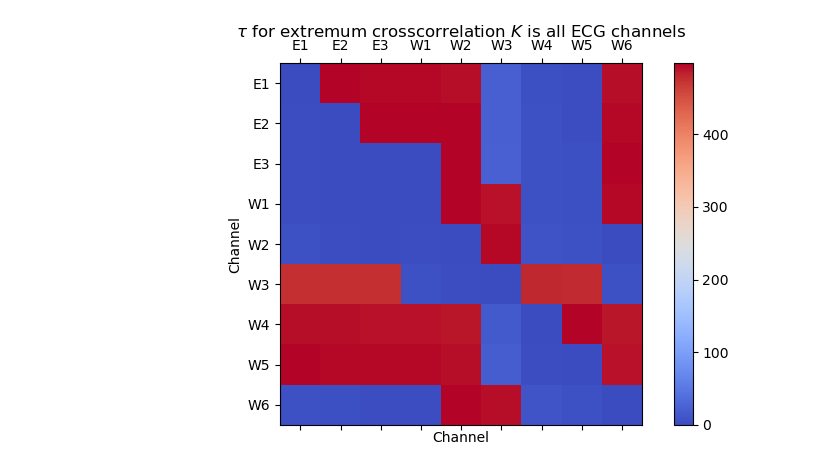

In [98]:
%matplotlib notebook
plt.matshow(tau, cmap='coolwarm')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.colorbar()
plt.title('$\\tau$ for extremum crosscorrelation $K$ is all ECG channels')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6'])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6'])
plt.show()

Again, there is no remarkable correlation outside $\tau=0$ or $\tau=Max$. Which is explained by the natural similarity of the signals. Except for channel $W3$ where $\tau=25$, more on that later. For a more detailed result all crosscorrelations are displayed in a singular diagram:

In [99]:
header = ['E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

r = []
for el in header:
    r_ = []
    for sel in header:
        r_.append(discrete_cross_correlation_normalized(data_simulated[el], data_simulated[sel], \
                                                        0, len(data_simulated[el])))
    r.append(r_)

<IPython.core.display.Javascript object>


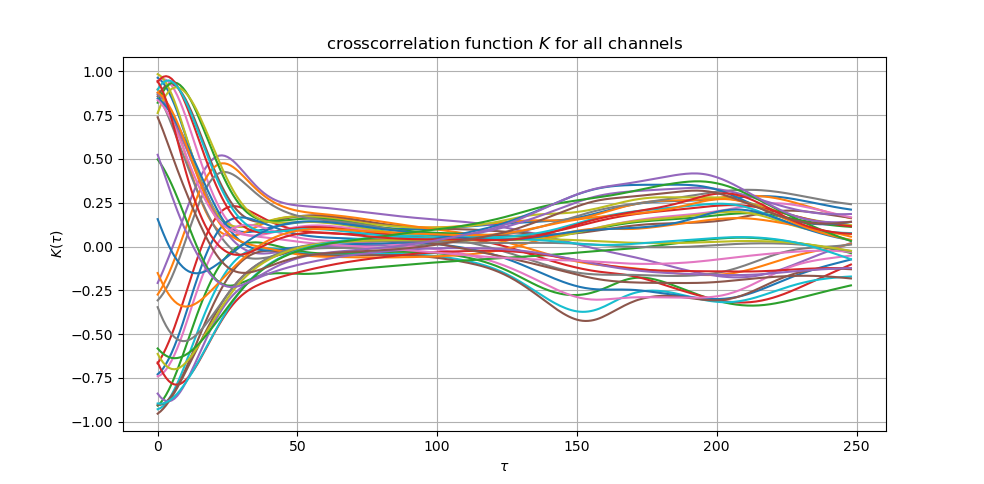

In [44]:
%matplotlib notebook

for i in range(len(r)):
    for j in range(len(r[i])):
        if i >= j: continue
        plt.plot(r[i][j], label='correlation %i,%i' % (i, j))


plt.grid()
#plt.legend()
plt.xlabel('$\\tau$')
plt.ylabel('$K(\\tau)$')
plt.title('crosscorrelation function $K$ for all channels')
plt.show()

The interpretation remains the same for all channels. Interestingly there seem to be some correlation between channel $W3$ and $E1 ... E3$ at around $\tau = 25$:

<IPython.core.display.Javascript object>


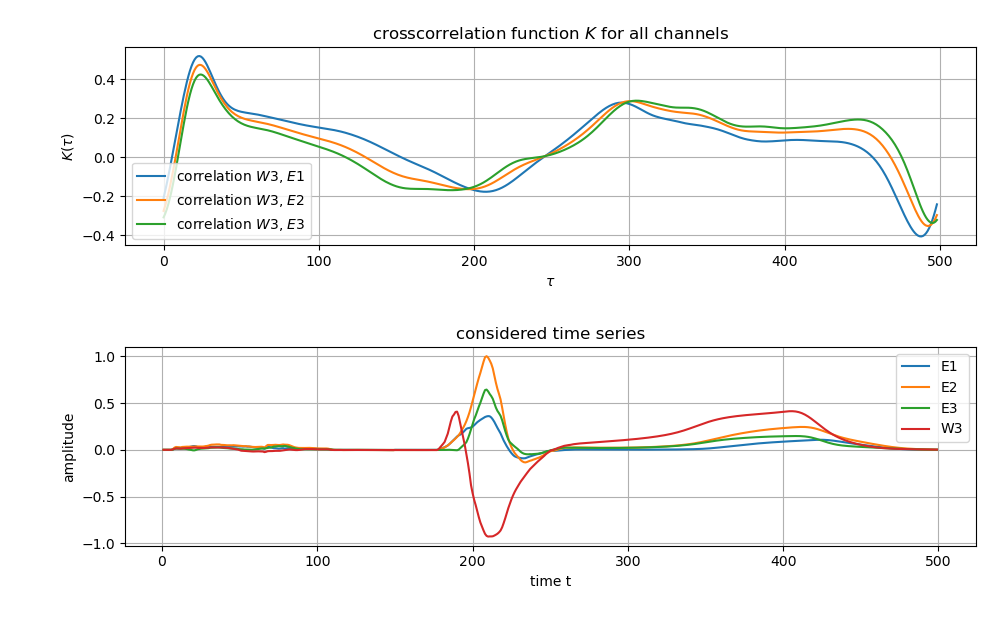

In [100]:
%matplotlib notebook
fig = plt.figure()

ax = fig.add_subplot(2, 1, 1)
ax.plot(r[0][5], label='correlation $W3$, $E1$')
ax.plot(r[1][5], label='correlation $W3$, $E2$')
ax.plot(r[2][5], label='correlation $W3$, $E3$')

ax.grid()
ax.legend()
ax.set_xlabel('$\\tau$')
ax.set_ylabel('$K(\\tau)$')
ax.set_title('crosscorrelation function $K$ for all channels')

ax = fig.add_subplot(2, 1, 2)
ax.plot(data_simulated['time'], data_simulated['E1'], label='E1')
ax.plot(data_simulated['time'], data_simulated['E2'], label='E2')
ax.plot(data_simulated['time'], data_simulated['E3'], label='E3')
ax.plot(data_simulated['time'], data_simulated['W3'], label='W3')

ax.grid()
ax.legend()
ax.set_xlabel('time t')
ax.set_ylabel('amplitude')
ax.set_title('considered time series')

fig.tight_layout()
fig.show()

Looking at the time series the reason for the crosscorrelation with $K\le0.5$ is obvious. The peak of $E1...E3$ follows the smaller peak of $W3$.

For further analysis longer time series need to be evaluated.